In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.gridspec import GridSpec

from sklearn.neighbors import KernelDensity
import numpy as np
import time
from shapely.geometry import box
import datetime

import nomad.io.base as loader
import nomad.city_gen as cg
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
from nomad.city_gen import City
from nomad.map_utils import blocks_to_mercator_gdf
from nomad.stop_detection.viz import plot_pings

In [28]:
# Parameters according to the config file
with open('config_no_ha.json', 'r', encoding='utf-8') as f:
    config = json.load(f)
    
# Load city and destination diary from config
#users = ['admiring_haibt']
users = loader.sample_users(config["output_files"]["diaries_path"], format='parquet', size = 600)

city = City.from_geopackage(config["city_file"])
traj_df = loader.sample_from_file(config["output_files"]["sparse_path"], format='parquet', users=users)
diaries_df = loader.sample_from_file(config["output_files"]["diaries_path"], format='parquet', users=users)
destinations = pd.read_csv(config["destination_diary_file"])

In [29]:
start_time = pd.to_datetime("2024-06-01 00:02:33")
end_time = start_time + datetime.timedelta(hours=2)

traj_df = traj_df.loc[(traj_df.datetime > start_time)&(traj_df.datetime < end_time)]

## Compute KDE

In [30]:
%%time
samples = traj_df[['x', 'y']].to_numpy()

kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(samples)

xmin, ymin = samples.min(axis=0)
xmax, ymax = samples.max(axis=0)

buffer = 30
xmin -= buffer; ymin -= buffer
xmax += buffer; ymax += buffer

grid_x = np.linspace(xmin, xmax, 500)
grid_y = np.linspace(ymin, ymax, 500)
xx, yy = np.meshgrid(grid_x, grid_y)

grid = np.column_stack((xx.ravel(), yy.ravel()))
dens = np.exp(kde.score_samples(grid)).reshape(xx.shape)

CPU times: total: 4min 14s
Wall time: 4min 15s


## Plotting densities

In [31]:
# set background geometries
buildings = blocks_to_mercator_gdf(city.buildings_gdf,
                                   block_size=15,
                                   false_easting=-4265699.0,
                                   false_northing=4392976.0)
bbox = gpd.GeoSeries(
    [box(xmin, ymin, xmax, ymax)],
    crs=buildings.crs
)
buildings = buildings.clip(bbox)

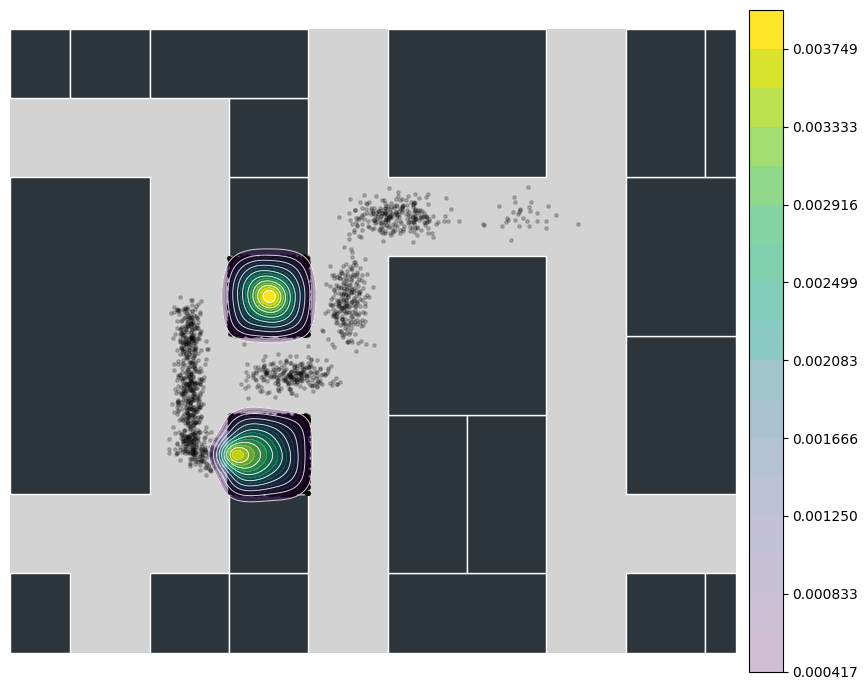

In [32]:
# -------- 2D map + KDE --------
fig, ax1 = plt.subplots(figsize=(9, 7))
ax1.set_axis_off()

# background + buildings
bbox.plot(ax=ax1, color='lightgray', zorder=0)
buildings.clip(bbox).plot(
    ax=ax1,
    edgecolor='white',
    linewidth=1,
    color='#2c353c',
    zorder=1
)

levels = np.linspace(0, dens.max(), 20)[2:]

from matplotlib import colormaps
base_cmap = colormaps["viridis"]
colors = base_cmap(np.linspace(0, 1, len(levels)))

colors[:, -1] = np.geomspace(0.25, 0.99, len(levels)) #logarithmic alpha ramp

alpha_cmap = mcolors.ListedColormap(colors)

plot_pings(traj_df, ax1, alpha=0.2)

cf = ax1.contourf(
    xx, yy, dens,
    levels=levels,
    cmap=alpha_cmap,
    zorder=2
)
ax1.contour(
    xx, yy, dens,
    levels=levels[::2],
    colors='white',
    linewidths=0.7,
    alpha=0.8,
    zorder=3
)

fig.colorbar(cf, ax=ax1, shrink=1, aspect=20, pad=0.015)
fig.tight_layout()
fig.savefig("kde_map_2d.png")


In [ ]:
# -------- 3D surface over map --------
fig3d = plt.figure(figsize=(10, 10))
ax2 = fig3d.add_subplot(111, projection='3d')

# background plane
ax2.plot_surface(
    np.array([[xmin, xmax], [xmin, xmax]]),
    np.array([[ymin, ymin], [ymax, ymax]]),
    np.full((2, 2), 0.0),
    color='lightgray'
)

# buildings as polygons
polys = []
for geom in buildings.clip(bbox).geometry:
    if geom.geom_type == "Polygon":
        x, y = geom.exterior.coords.xy
        polys.append(list(zip(x, y, [0.0] * len(x))))

pc = Poly3DCollection(
    polys,
    facecolor="gray",
    edgecolor="white",
    linewidth=0.5
)
ax2.add_collection3d(pc)

# density surface, masked below first level
zmin = levels[0]
dens_masked = np.where(dens >= zmin, dens, np.nan)
ax2.plot_surface(
    xx, yy, dens_masked,
    cmap='viridis',
    linewidth=0,
    antialiased=False,
    alpha=0.35,
    rcount=300,
    ccount=300
)

# fix limits and aspect to kill the weird zoom

ax2.view_init(elev=35, azim=-65)
ax2.set_axis_off()

fig3d.savefig("kde_map_3d.png")
plt.show()